In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy.io

In [2]:
#helper functions from: https://github.com/meichlseder/pyascon/tree/1ad51b091d2233a29beb2e7b5136f791cf5100ff

def ascon_initialize_1st_round(S, k, rate, a, b, key, nonce):
    """
    Ascon initialization phase - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    k: key size in bits
    rate: block size in bytes (8 for Ascon-128, Ascon-80pq; 16 for Ascon-128a)
    a: number of initialization/finalization rounds for permutation
    b: number of intermediate rounds for permutation
    key: a bytes object of size 16 (for Ascon-128, Ascon-128a; 128-bit security) or 20 (for Ascon-80pq; 128-bit security)
    nonce: a bytes object of size 16
    returns nothing, updates S
    """
    iv_zero_key_nonce = to_bytes([k, rate * 8, a, b] + (20-len(key))*[0]) + key + nonce
    S[0], S[1], S[2], S[3], S[4] = bytes_to_state(iv_zero_key_nonce)

    S_input = copy.deepcopy(S)
    ascon_permutation_1st_round(S) #just first round

    S_output = S
    return S_input, S_output

def ascon_permutation_1st_round(S):
    """
    Ascon core permutation for the sponge construction - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    rounds: number of rounds to perform
    returns nothing, updates S
    """
    if debugpermutation: printwords(S, "permutation input:")
        
    # --- add round constants ---
    S[2] ^= 0xf0
    if debugpermutation: printwords(S, "round constant addition:")
    # --- substitution layer ---
    S[0] ^= S[4]
    S[4] ^= S[3]
    S[2] ^= S[1]
    T = [(S[i] ^ 0xFFFFFFFFFFFFFFFF) & S[(i+1)%5] for i in range(5)]
    for i in range(5):
        S[i] ^= T[(i+1)%5]
    S[1] ^= S[0]
    S[0] ^= S[4]
    S[3] ^= S[2]
    S[2] ^= 0XFFFFFFFFFFFFFFFF
    if debugpermutation: printwords(S, "substitution layer:")
    # --- linear diffusion layer ---
    S[0] ^= rotr(S[0], 19) ^ rotr(S[0], 28)
    S[1] ^= rotr(S[1], 61) ^ rotr(S[1], 39)
    S[2] ^= rotr(S[2],  1) ^ rotr(S[2],  6)
    S[3] ^= rotr(S[3], 10) ^ rotr(S[3], 17)
    S[4] ^= rotr(S[4],  7) ^ rotr(S[4], 41)
    if debugpermutation: printwords(S, "linear diffusion layer:")
            
            
# === helper functions ===

def get_random_bytes(num):
    import os
    return to_bytes(os.urandom(num))

def zero_bytes(n):
    return n * b"\x00"

def to_bytes(l): # where l is a list or bytearray or bytes
    return bytes(bytearray(l))

def bytes_to_int(bytes):
    return sum([bi << ((len(bytes) - 1 - i)*8) for i, bi in enumerate(to_bytes(bytes))])

def bytes_to_state(bytes):
    return [bytes_to_int(bytes[8*w:8*(w+1)]) for w in range(5)]

def int_to_bytes(integer, nbytes):
    return to_bytes([(integer >> ((nbytes - 1 - i) * 8)) % 256 for i in range(nbytes)])

def rotr(val, r):
    return (val >> r) | ((val & (1<<r)-1) << (64-r))

def bytes_to_hex(b):
    return b.hex()
    #return "".join(x.encode('hex') for x in b)

def printstate(S, description=""):
    print(" " + description)
    print(" ".join(["{s:016x}".format(s=s) for s in S]))

def printwords(S, description=""):
    print(" " + description)
    print("\n".join(["  x{i}={s:016x}".format(**locals()) for i, s in enumerate(S)]))


# === some demo if called directly ===

def demo_print(data):
    maxlen = max([len(text) for (text, val) in data])
    for text, val in data:
        print("{text}:{align} 0x{val} ({length} bytes)".format(text=text, align=((maxlen - len(text)) * " "), val=bytes_to_hex(val), length=len(val)))

In [3]:
# added helper functions
def state_to_int320(state):
    state_int320 = (state[0]<<4*64)+(state[1]<<3*64)+(state[2]<<2*64)+(state[3]<<64)+state[4]
    return state_int320

In [4]:
variant          = "Ascon-128"
debug            = 0
debugpermutation = 0
keysize          = 20 if variant == "Ascon-80pq" else 16

a                = 12 # rounds
b                = 8  if variant == "Ascon-128a" else 6   # rounds
rate             = 16 if variant == "Ascon-128a" else 8   # rate in bytes

In [5]:
for acquisition_number in tqdm.trange(1,2):

    filename = 'fpga_ascon_100k_acq_'+str(acquisition_number)+'.mat'
    X        = scipy.io.loadmat(filename)
    traces   = X['traces'] if acquisition_number == 1 else np.vstack((traces,X['traces']))
    nonces   = X['nonce']  if acquisition_number == 1 else np.vstack((nonces,X['nonce']))

print(np.shape(traces),np.shape(nonces))

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]

(1000000, 200) (1000000, 16)


In [6]:
key = np.array([ 43, 126,  21,  22,  40, 174, 210, 166, 171, 247,  21, 136,   9,  207,  79,  60]).astype('uint8')
key = to_bytes(np.flip(key))
#print(key)

In [7]:
num_traces = len(traces)
hyp_traces = np.zeros((num_traces,1))

for i in range(num_traces):    
    S                 = [0, 0, 0, 0, 0]
    k                 = len(key) * 8              # bits
    noncein             = to_bytes(np.flip(nonces[i,:]))      
    S_input, S_output = ascon_initialize_1st_round(S, k, rate, a, b, key, noncein)
    #hyp_traces[i,:] = bin(state_to_int320(S_output)).count("1")
    hyp_traces[i,:] = bin(state_to_int320(S_input)^state_to_int320(S_output)).count("1")
    #hyp_traces[i,:] = bin(bytes_to_int(noncein)).count("1")

In [8]:
def evaluate_corr(traces,hyp_pwr):
    
    num_samples    = np.shape(traces)[1]
    traces_hyp_pwr = np.concatenate((traces,hyp_pwr),axis=1)
    corr_matrix    = np.corrcoef(traces_hyp_pwr.T)
    
    return corr_matrix[num_samples,0:num_samples]

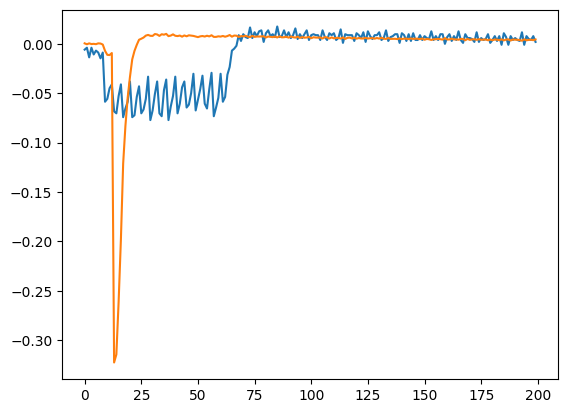

In [9]:
corr_trace = evaluate_corr(traces,hyp_traces)
plt.plot(traces[0,:])
plt.plot(corr_trace)

In [10]:
max_corr_sample = np.argmax(np.abs(corr_trace))
traces = traces[:,max_corr_sample].reshape(-1,1)

In [11]:
# traces = traces[:,13].reshape(-1,1)
# traces = hyp_traces

In [25]:
key_int_values = [x for x in key]
print(key_int_values)

[60, 79, 207, 9, 136, 21, 247, 171, 166, 210, 174, 40, 22, 21, 126, 43]


In [12]:
def find_key_reg1_hypothesis(key_reg1,bit_position):
    
    key_reg1_int = bytes_to_int(key_reg1)
    k0  = (key_reg1_int         >>(63-bit_position)) & 1
    k45 = (rotr(key_reg1_int,19)>>(63-bit_position)) & 1
    k36 = (rotr(key_reg1_int,28)>>(63-bit_position)) & 1
    
    return k0,k45,k36

def find_key_reg12_hypothesis(key_reg1,key_reg2,bit_position):
    
    key_reg12_int = bytes_to_int(key_reg1)^bytes_to_int(key_reg2)
    k0  = (key_reg12_int         >>(63-bit_position)) & 1
    k3  = (rotr(key_reg12_int,61)>>(63-bit_position)) & 1
    k25 = (rotr(key_reg12_int,39)>>(63-bit_position)) & 1
    
    return k0,k3,k25

In [13]:
def find_nonce_bits_r1(nonce,bit_position):
    
    nonce_reg1_int = bytes_to_int(nonce[0:8])
    nonce_reg2_int = bytes_to_int(nonce[8:16])
        
    n64  = (nonce_reg2_int         >>(63-bit_position)) & 1
    n0   = (nonce_reg1_int         >>(63-bit_position)) & 1
    n109 = (rotr(nonce_reg2_int,19)>>(63-bit_position)) & 1
    n45  = (rotr(nonce_reg1_int,19)>>(63-bit_position)) & 1
    n100 = (rotr(nonce_reg2_int,28)>>(63-bit_position)) & 1
    n36  = (rotr(nonce_reg1_int,28)>>(63-bit_position)) & 1
    
    return n64,n0,n109,n45,n100,n36

def find_nonce_bits_r2(nonce,bit_position):
    
    nonce_reg1_int = bytes_to_int(nonce[0:8])
    nonce_reg2_int = bytes_to_int(nonce[8:16])
        
    n0   = (nonce_reg1_int         >>(63-bit_position)) & 1
    n64  = (nonce_reg2_int         >>(63-bit_position)) & 1
    n3   = (rotr(nonce_reg1_int,61)>>(63-bit_position)) & 1
    n67  = (rotr(nonce_reg2_int,61)>>(63-bit_position)) & 1
    n25  = (rotr(nonce_reg1_int,39)>>(63-bit_position)) & 1
    n89  = (rotr(nonce_reg2_int,39)>>(63-bit_position)) & 1
    
    return n0,n64,n3,n67,n25,n89

In [14]:
def evaluate_corr(traces,hyp_pwr):
    
    num_samples    = np.shape(traces)[1]
    traces_hyp_pwr = np.concatenate((traces,hyp_pwr),axis=1)
    corr_matrix    = np.corrcoef(traces_hyp_pwr.T)
    
    return corr_matrix[num_samples,0:num_samples]

Key Reg 1: 4345919805280614315


100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [50:18<00:00, 47.17s/it]


Recovered Key Reg1: 4345920355036427691
MTD: 999999


Text(0, 0.5, 'Success Rate (%)')

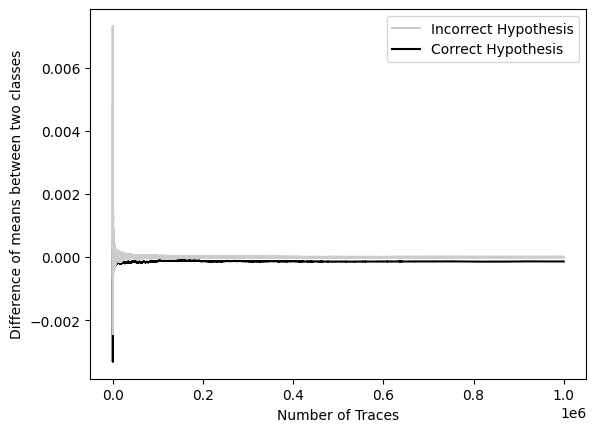

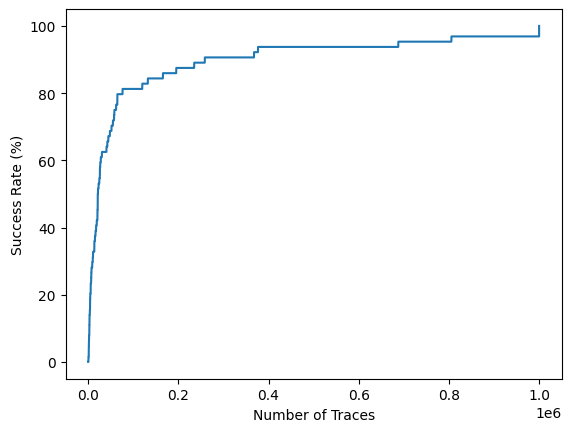

In [15]:
recovered_key_bits = []
key_reg1           = key[0:8]
key_reg1_int       = bytes_to_int(key_reg1)
print("Key Reg 1:",key_reg1_int)

MTD_bit = []

for bit_position_to_attack in tqdm.trange(64):

    k0,k45,k36  = find_key_reg1_hypothesis(key_reg1,bit_position_to_attack)
    correct_hyp = (k0<<2)|(k45<<1)|k36
    #print(correct_hyp)

    hyp_pwr = np.zeros((num_traces,8))

    for i in range(num_traces):
        for j in range(8):
            k0,k45,k36 = (j>>2)&1, (j>>1)&1, (j&1) 
            #print(k2,k1,k0)
            n64,n0,n109,n45,n100,n36 = find_nonce_bits_r1(np.flip(nonces[i]),bit_position_to_attack)

            #selection_function = (k0&(n64^1))^n0^(k45&(n109^1))^n45^(k36&(n100^1))^n36
            selection_function = (k0&(n64))^n0^(k45&(n109))^n45^(k36&(n100))^n36
            hyp_pwr[i,j] = selection_function
            
    diff       = np.zeros((num_traces,8))

    zero_count = np.zeros((1,8))
    one_count  = np.zeros((1,8))

    sum_zero   = np.zeros((1,8))
    sum_one    = np.zeros((1,8))

    for i in range(num_traces):

        zero_count = zero_count + (hyp_pwr[i,:] == 0)
        one_count  = one_count  + (hyp_pwr[i,:] == 1)

        sum_zero   = sum_zero+traces[i,:]*(hyp_pwr[i,:] == 0)
        sum_one    = sum_one +traces[i,:]*(hyp_pwr[i,:] == 1)

        if np.all(one_count != 0) & np.all(zero_count != 0):
            diff[i,:] = sum_one/one_count - sum_zero/zero_count
    
    recovered_key_bits.append(np.argmax(abs(diff[i,:]))>>2 & 1)
    
    MTD_bit_intermediate = np.where((np.argmax(abs(diff),axis=1)>>2) & 1 != (correct_hyp>>2) & 1)[0]
    if len(MTD_bit_intermediate) == 0:
        MTD_bit.append(0)
    else:
        MTD_bit.append(MTD_bit_intermediate[-1])
    
recovered_key_reg1 = int(''.join(str(recovered_key_bits[i]) for i in range(64)),2)
print("Recovered Key Reg1:",recovered_key_reg1)
print("MTD:",int(np.max(MTD_bit)))

mdic = {"traces": traces, "nonces":nonces, "key":key_int_values, "recovered_key_bits":recovered_key_bits, "MTD_bit":MTD_bit}
scipy.io.savemat("DPA_ASCON_INITIALIZATION_measured_traces_results_key_reg1.mat", mdic)

ly = 0
for i in range(8):
    if i == correct_hyp:
        plt.plot(diff[:,i],color=(0,0,0))
    else:
        if ly == 0:
            plt.plot(diff[:,i],color=(0.8,0.8,0.8))
            ly = 1
        else:
            plt.plot(diff[:,i],color=(0.8,0.8,0.8),label='_nolegend_')
        
plt.xlabel("Number of Traces")
plt.ylabel("Difference of means between two classes")
if correct_hyp == 0:
    plt.legend(["Correct Hypothesis","Incorrect Hypothesis"])
else:
    plt.legend(["Incorrect Hypothesis","Correct Hypothesis"])
    
count = np.zeros((num_traces,1))

for i in range(len(MTD_bit)):
    count[MTD_bit[i]:] = count[MTD_bit[i]:]+1

plt.figure()
plt.plot(count/64*100)
plt.xlabel("Number of Traces")
plt.ylabel("Success Rate (%)")

In [16]:
bin(key_reg1_int^recovered_key_reg1)

'0b1000000000000000000000000000001000000000'

Key Reg 12: 11141167850197125504
Key Reg 2:  12020861842597707307


100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [50:21<00:00, 47.20s/it]


Recovered Key Reg2: 12020862392353519659
MTD: 999999


Text(0, 0.5, 'Success Rate (%)')

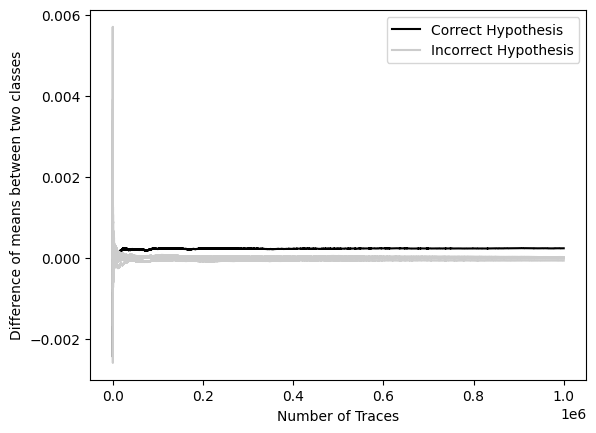

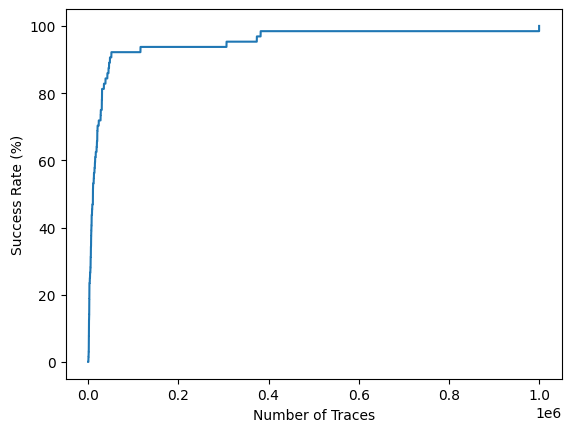

In [17]:
#attacking key reg2

recovered_key_bits = []
key_reg2           = key[8:16]
key_reg2_int       = bytes_to_int(key_reg2)

print("Key Reg 12:",key_reg1_int^key_reg2_int)
print("Key Reg 2: ",key_reg2_int)

MTD_bit = []

for bit_position_to_attack in tqdm.trange(64):

    k0,k3,k25   = find_key_reg12_hypothesis(key_reg1,key_reg2,bit_position_to_attack)
    correct_hyp = (k0<<2)|(k3<<1)|k25

    hyp_pwr = np.zeros((num_traces,8))

    for i in range(num_traces):
        for j in range(8):
            k0,k3,k25 = (j>>2)&1, (j>>1)&1, (j&1) 
            n0,n64,n3,n67,n25,n89 = find_nonce_bits_r2(np.flip(nonces[i]),bit_position_to_attack)
            if bit_position_to_attack >=56 and bit_position_to_attack < 60:
                selection_function = (n0 & (k0))^n64^(n3 & (1^k3))^n67^(n25 & (1^k25))^n89
            else:
                selection_function = (n0 & (1^k0))^n64^(n3 & (1^k3))^n67^(n25 & (1^k25))^n89
            hyp_pwr[i,j] = selection_function
            
    diff       = np.zeros((num_traces,8))

    zero_count = np.zeros((1,8))
    one_count  = np.zeros((1,8))

    sum_zero   = np.zeros((1,8))
    sum_one    = np.zeros((1,8))

    for i in range(num_traces):

        zero_count = zero_count + (hyp_pwr[i,:] == 0)
        one_count  = one_count  + (hyp_pwr[i,:] == 1)

        sum_zero   = sum_zero+traces[i,:]*(hyp_pwr[i,:] == 0)
        sum_one    = sum_one +traces[i,:]*(hyp_pwr[i,:] == 1)

        if np.all(one_count != 0) & np.all(zero_count != 0):
            diff[i,:] = sum_one/one_count - sum_zero/zero_count
    
    #print(correct_hyp,np.argmax(abs(diff[i,:])))
    recovered_key_bits.append(np.argmax(abs(diff[i,:]))>>2)
    
    MTD_bit_intermediate = np.where((np.argmax(abs(diff),axis=1)>>2) & 1 != (correct_hyp>>2) & 1)[0]
    if len(MTD_bit_intermediate) == 0:
        MTD_bit.append(0)
    else:
        MTD_bit.append(MTD_bit_intermediate[-1])

recovered_key_reg12 = int(''.join(str(recovered_key_bits[i]) for i in range(64)),2)
recovered_key_reg2  = recovered_key_reg12^recovered_key_reg1

print("Recovered Key Reg2:",recovered_key_reg2)
print("MTD:",int(np.max(MTD_bit)))

# diff = []

# for i in range(8):
#     idx0 = np.where(np.array(hyp_pwr[:,i])==0)
#     idx1 = np.where(np.array(hyp_pwr[:,i])==1)

#     diff.append(sum(traces[idx0])/len(idx0[0])-sum(traces[idx1])/len(idx1[0]))
    
# plt.stem(np.abs(np.array(diff)))

ly = 0
for i in range(8):
    if i == correct_hyp:
        plt.plot(diff[:,i],color=(0,0,0))
    else:
        if ly == 0:
            plt.plot(diff[:,i],color=(0.8,0.8,0.8))
            ly = 1
        else:
            plt.plot(diff[:,i],color=(0.8,0.8,0.8),label='_nolegend_')
        
plt.xlabel("Number of Traces")
plt.ylabel("Difference of means between two classes")
if correct_hyp == 0:
    plt.legend(["Correct Hypothesis","Incorrect Hypothesis"])
else:
    plt.legend(["Incorrect Hypothesis","Correct Hypothesis"])
    
count = np.zeros((num_traces,1))

for i in range(len(MTD_bit)):
    count[MTD_bit[i]:] = count[MTD_bit[i]:]+1
plt.figure()    
plt.plot(count/64*100)
plt.xlabel("Number of Traces")
plt.ylabel("Success Rate (%)")

In [18]:
bin(key_reg2_int^recovered_key_reg2)

'0b1000000000000000000000000000011000000000'

In [19]:
mdic = {"traces": traces, "nonces":nonces, "key":key_int_values, "recovered_key_bits":recovered_key_bits, "MTD_bit":MTD_bit}
scipy.io.savemat("DPA_ASCON_INITIALIZATION_measured_traces_results_key_reg2.mat", mdic)

In [26]:
mdic = {"diff": diff, "correct_hyp":correct_hyp}
scipy.io.savemat("DPA_ASCON_INITIALIZATION_hypothesis_evolution.mat", mdic)